In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os

data_dir = r"C:\Users\YASHU\Documents\Unified\Projects Done\Animal Classification\dataset"
batch_size = 32
img_size = (224, 224)

### Training and Validation data generators

In [3]:
# Data augmentation and rescaling
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 1561 images belonging to 15 classes.
Found 383 images belonging to 15 classes.


### Transfer Learning- MobileNetV2 Model

In [4]:
# pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze convolutional base

# custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(15, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
l
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])




9406464/9406464 [==============================] - 10s 1us/step


### Model Training

In [6]:
epochs = 20
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=epochs
)

Epoch 1/20
48/48 [==============================] - 80s 2s/step - loss: 0.6773 - accuracy: 0.7940 - val_loss: 0.5858 - val_accuracy: 0.8125
Epoch 2/20
48/48 [==============================] - 63s 1s/step - loss: 0.5286 - accuracy: 0.8352 - val_loss: 0.5268 - val_accuracy: 0.8381
Epoch 3/20
48/48 [==============================] - 61s 1s/step - loss: 0.4528 - accuracy: 0.8581 - val_loss: 0.5700 - val_accuracy: 0.8239
Epoch 4/20
48/48 [==============================] - 59s 1s/step - loss: 0.4353 - accuracy: 0.8600 - val_loss: 0.5851 - val_accuracy: 0.8097
Epoch 5/20
48/48 [==============================] - 69s 1s/step - loss: 0.3780 - accuracy: 0.8816 - val_loss: 0.7412 - val_accuracy: 0.7812
Epoch 6/20
48/48 [==============================] - 73s 2s/step - loss: 0.3813 - accuracy: 0.8790 - val_loss: 0.6293 - val_accuracy: 0.8068
Epoch 7/20
48/48 [==============================] - 65s 1s/step - loss: 0.3419 - accuracy: 0.8895 - val_loss: 0.6262 - val_accuracy: 0.8068
Epoch 8/20
48/48 [==

### Training and Validation Accuracy

In [7]:
print("Final training accuracy:", history.history['accuracy'][-1])
print("Final validation accuracy:", history.history['val_accuracy'][-1])

Final training accuracy: 0.9372138381004333
Final validation accuracy: 0.8380681872367859


### Fine-Tuning the Model

In [8]:
base_model.trainable = True
for layer in base_model.layers[:100]:  # Freeze first 100 layers
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

fine_tune_epochs = 10
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=fine_tune_epochs
)

print("Fine-tuning final training accuracy:", history_fine.history['accuracy'][-1])
print("Fine-tuning final validation accuracy:", history_fine.history['val_accuracy'][-1])

Epoch 1/10
48/48 [==============================] - 94s 2s/step - loss: 0.6399 - accuracy: 0.8143 - val_loss: 0.4355 - val_accuracy: 0.8665
Epoch 2/10
48/48 [==============================] - 83s 2s/step - loss: 0.4357 - accuracy: 0.8725 - val_loss: 0.5222 - val_accuracy: 0.8210
Epoch 3/10
48/48 [==============================] - 77s 2s/step - loss: 0.2995 - accuracy: 0.8980 - val_loss: 0.5395 - val_accuracy: 0.8210
Epoch 4/10
48/48 [==============================] - 85s 2s/step - loss: 0.3022 - accuracy: 0.9058 - val_loss: 0.5184 - val_accuracy: 0.8381
Epoch 5/10
48/48 [==============================] - 81s 2s/step - loss: 0.2635 - accuracy: 0.9156 - val_loss: 0.5429 - val_accuracy: 0.8295
Epoch 6/10
48/48 [==============================] - 91s 2s/step - loss: 0.2537 - accuracy: 0.9196 - val_loss: 0.4440 - val_accuracy: 0.8551
Epoch 7/10
48/48 [==============================] - 89s 2s/step - loss: 0.2342 - accuracy: 0.9202 - val_loss: 0.4013 - val_accuracy: 0.8665
Epoch 8/10
48/48 [==

In [11]:
# Save the trained model
model.save('animal_classification_model.h5')

print("Model training complete and saved as 'animal_classification_model.h5'")

C:\Users\YASHU\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model training complete and saved as 'animal_classification_model.h5'


### Model on Test data

In [9]:
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print("Test accuracy:", test_accuracy)
print("Test loss:", test_loss)

Found 1944 images belonging to 15 classes.
60/60 [==============================] - 44s 732ms/step - loss: 0.0848 - accuracy: 0.9750
Test accuracy: 0.9750000238418579
Test loss: 0.08483850210905075


### Results Visualization

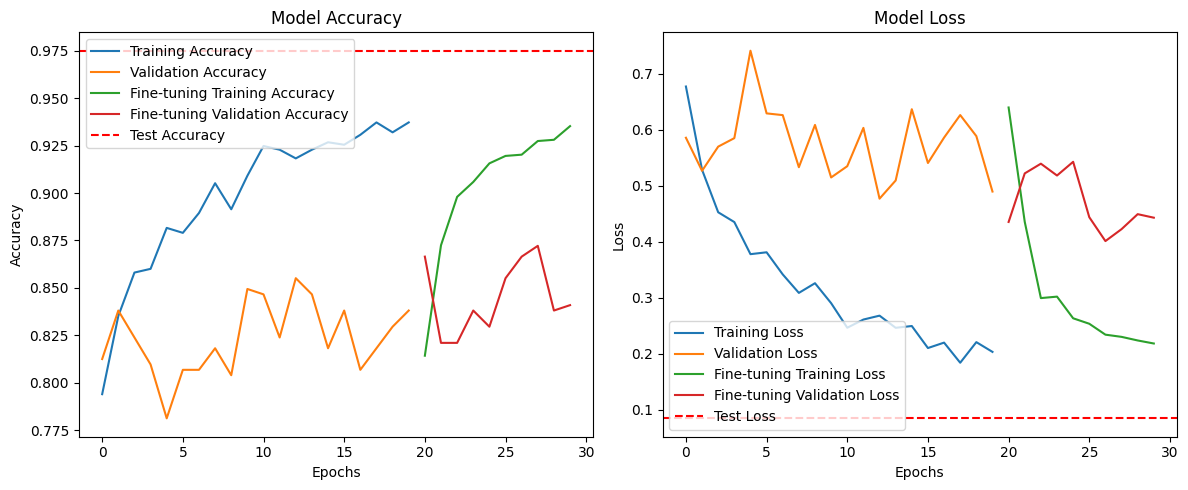

In [10]:
import matplotlib.pyplot as plt

# training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot([epochs + i for i in range(fine_tune_epochs)], history_fine.history['accuracy'], label='Fine-tuning Training Accuracy')
plt.plot([epochs + i for i in range(fine_tune_epochs)], history_fine.history['val_accuracy'], label='Fine-tuning Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot([epochs + i for i in range(fine_tune_epochs)], history_fine.history['loss'], label='Fine-tuning Training Loss')
plt.plot([epochs + i for i in range(fine_tune_epochs)], history_fine.history['val_loss'], label='Fine-tuning Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### Model testing on random animal images apart from the dataset

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

model = tf.keras.models.load_model('animal_classification_model.h5')

class_labels = [
    'Bear', 'Bird', 'Cat', 'Cow', 'Deer', 'Dog', 'Dolphin', 
    'Elephant', 'Giraffe', 'Horse', 'Kangaroo', 'Lion', 
    'Panda', 'Tiger', 'Zebra'
]

def predict_animal(image_path):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array /= 255.0 

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0]) * 100

    plt.imshow(img)
    plt.title(f"Predicted: {class_labels[predicted_class]} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

    print(f"Predicted Animal: {class_labels[predicted_class]}")
    print(f"Confidence: {confidence:.2f}%")

1/1 [==============================] - 1s 678ms/step


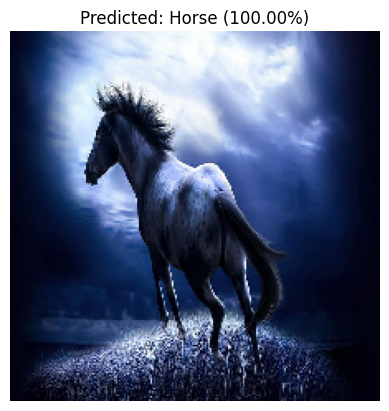

Predicted Animal: Horse
Confidence: 100.00%


In [8]:
image_path = r"C:\Users\YASHU\Downloads\download.jpeg"
predict_animal(image_path)